# Debugging instability new configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import glob
import netCDF4 as nc
import sys
sys.path.append('/home/users/birgal/')

In [2]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability/'

ds = xr.open_dataset(f'{folder}output.abort_0000.nc', drop_variables=['x', 'y'])

### New domain 1ts based debugging

Time step size: 100 s

Error region:
```
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 60 |ssh| max   4.662     at i j    340 395     MPI rank 568
 kt 60 |U|   max   10.06     at i j k 1050 383 120 MPI rank 596
 kt 60 Sal   min   25.86     at i j k 1052 406 120 MPI rank 655
 kt 60 Sal   max   35.36     at i j k  362 220  33 MPI rank 146
```

In [6]:
dss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc')

(5800.0, 5200.0)

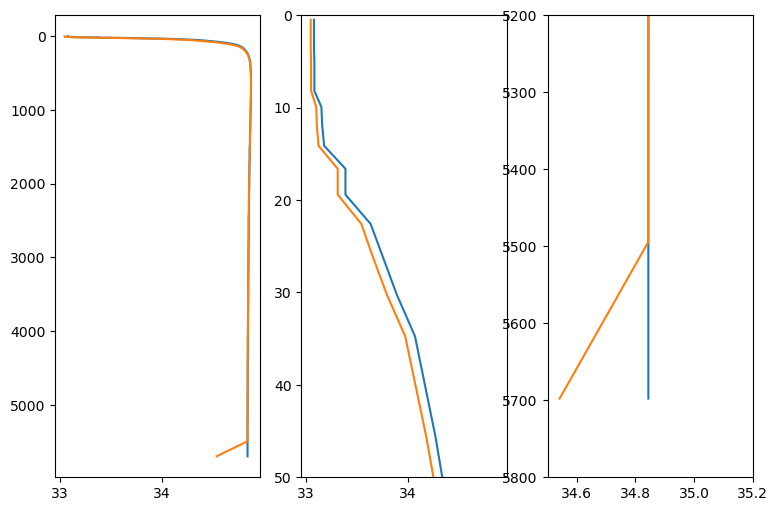

In [25]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(dss.SALT.sel(x=1050, y=383), dfT.deptht)
    axis.plot(dss.SALT.sel(x=1051, y=383), dfT.deptht)

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.5,35.2)
ax[2].set_ylim(5800,5200)

## temperature looks normal

In [4]:
folder_1ts = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability-1ts/'
dfT = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_T_19790101010640-19790101013959.nc')
# dfU = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_U_19790101010640-19790101013959.nc')
# dfV = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_V_19790101010640-19790101013959.nc')
# dfW = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_W_19790101010640-19790101013959.nc')

In [27]:
# salinity = 34.541 at depth level > 110 (fresher water underneath saltier is causing the instability)
# --- could be because of the fill_value for the few locations that didn't have
# --- initial condition profiles also look sort of steppy which doesn't quite seem right, probably because of my vertical interpolation method. Reconsider?
# --> consider using https://xgcm.readthedocs.io/en/latest/transform.html instead for vertical interpolation
# --- or especially for boundary conditions, could consider interpolating with cf along slices of x, z 

In [10]:
T2d

<xarray.Dataset>
Dimensions:  (z: 52, y: 439, x: 1440)
Coordinates:
  * z        (z) float32 2.1 6.7 12.15 18.55 ... 4.6e+03 5e+03 5.4e+03 5.8e+03
    drF      (z) float32 ...
    rhoRef   (z) float32 ...
Dimensions without coordinates: y, x
Data variables:
    THETA    (z, y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [17]:
z_top_edge[:,0,0]

array([0.0000000e+00, 4.1999998e+00, 9.1999998e+00, 1.5099999e+01,
       2.2000000e+01, 3.0500000e+01, 4.0000000e+01, 5.0000000e+01,
       6.0000000e+01, 7.0000000e+01, 8.0000000e+01, 9.0000000e+01,
       1.0000000e+02, 1.1000000e+02, 1.2000000e+02, 1.3000000e+02,
       1.4000000e+02, 1.5300000e+02, 1.7000000e+02, 1.9000000e+02,
       2.1000000e+02, 2.3000000e+02, 2.5000000e+02, 2.7000000e+02,
       2.9000000e+02, 3.1200000e+02, 3.4200000e+02, 3.8000000e+02,
       4.2500000e+02, 4.7500000e+02, 5.2500000e+02, 5.7800000e+02,
       6.5000000e+02, 7.5000000e+02, 8.5000000e+02, 9.5000000e+02,
       1.0500000e+03, 1.1500000e+03, 1.3000000e+03, 1.5000000e+03,
       1.7000000e+03, 1.9000000e+03, 2.1200000e+03, 2.4200000e+03,
       2.8000000e+03, 3.2000000e+03, 3.6000000e+03, 4.0000000e+03,
       4.4000000e+03, 4.8000000e+03, 5.2000000e+03, 5.6000000e+03],
      dtype=float32)

In [18]:
# Try vertical interpolation with xgcm: https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-transformation
from nemo_python.ics_obcs import vertical_edges

# step (1) --- make variable into an extensive (volume-weighted) property:
dst = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-THETA-horizontal-interp.nc')

SOSE_coord      = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')
SOSE_coord['Z'] = abs(SOSE_coord['Z'])
SOSE_coord      = SOSE_coord.rename({'Z':'z'})
(z_top_edge, z_centres, z_bot_edge) = vertical_edges(SOSE_coord, mtype='SOSE')

T2d_weighted = dst.THETA*SOSE_coord.drF

T2d['THETA'] = T2d_weighted
T2d = T2d.assign_coords({'zc': z_top_edge[:,0,0]})

# step (2) --- recreate the grid object with a staggered `center`/`outer` coordinate layout
grid = Grid(T2d, coords={'Z':{'center':'z', 'outer':'zc'}}, periodic=False)
# grid_top_edge

# step(3) --- interpolate theta to outer coordinate of grid object
T2d['theta_outer'] = grid.interp(T2d.THETA, 'Z', boundary='fill')
T2d['theta_outer']

# step (4) --- transform the data using the conservative method.
# define the target values in density
nemo_depths_target = np.linspace(0,6000, 121) # arbitrary

# and transform
phi_transformed_cons = grid.transform(T2d.THETA, 'Z', nemo_depths_target, method='conservative', target_data=T2d.theta_outer)

ValueError: conflicting sizes for dimension 'zc': length 53 on <this-array> and length 52 on {'zc': 'zc', 'y': <this-array>, 'x': <this-array>} - does your grid ufunc correctly trim off the same number of elements which were added by padding using boundary_width={'X': (1, 1)}?

In [41]:
dst.THETA.isel(z=10, y=355, x=1050).values

array(-1.31604088)

In [39]:
(dst.z*dst.THETA).isel(z=10, y=355, x=1050).values

array(-1.63732414)

In [40]:
-0.78*2.1

-1.6380000000000001

In [44]:
dst.z

<xarray.DataArray 'z' (z: 52)>
array([2.100e+00, 6.700e+00, 1.215e+01, 1.855e+01, 2.625e+01, 3.525e+01,
       4.500e+01, 5.500e+01, 6.500e+01, 7.500e+01, 8.500e+01, 9.500e+01,
       1.050e+02, 1.150e+02, 1.250e+02, 1.350e+02, 1.465e+02, 1.615e+02,
       1.800e+02, 2.000e+02, 2.200e+02, 2.400e+02, 2.600e+02, 2.800e+02,
       3.010e+02, 3.270e+02, 3.610e+02, 4.025e+02, 4.500e+02, 5.000e+02,
       5.515e+02, 6.140e+02, 7.000e+02, 8.000e+02, 9.000e+02, 1.000e+03,
       1.100e+03, 1.225e+03, 1.400e+03, 1.600e+03, 1.800e+03, 2.010e+03,
       2.270e+03, 2.610e+03, 3.000e+03, 3.400e+03, 3.800e+03, 4.200e+03,
       4.600e+03, 5.000e+03, 5.400e+03, 5.800e+03], dtype=float32)
Coordinates:
  * z        (z) float32 2.1 6.7 12.15 18.55 ... 4.6e+03 5e+03 5.4e+03 5.8e+03

In [5]:
dfT.isel(time_counter=slice())

<xarray.Dataset>
Dimensions:                (y_grid_T: 453, x_grid_T: 1440, nvertex_grid_T: 4,
                            deptht: 121, axis_nbounds: 2, time_counter: 20,
                            y_grid_T_inner: 453, x_grid_T_inner: 1440)
Coordinates:
    nav_lat_grid_T         (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T         (y_grid_T, x_grid_T) float32 ...
  * deptht                 (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_centered          (time_counter) datetime64[ns] ...
  * time_counter           (time_counter) datetime64[ns] 1979-01-01T01:07:30 ...
Dimensions without coordinates: y_grid_T, x_grid_T, nvertex_grid_T,
                                axis_nbounds, y_grid_T_inner, x_grid_T_inner
Data variables: (12/15)
    bounds_nav_lon_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    bounds_nav_lat_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    area_grid_T            (y_grid_T, x_grid_T) float32 ...
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    time_centered_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds    (time_counter, axis_nbounds) datetime64[ns] ...
    ...                     ...
    zos                    (time_counter, y_grid_T, x_grid_T) float32 ...
    mldr10_1               (time_counter, y_grid_T, x_grid_T) float32 ...
    sbt                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sbs                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sosst                  (time_counter, y_grid_T, x_grid_T) float32 ...
    sosss                  (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    name:         eANT025.L121_1ts_19790101_19790128_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Jan-17 17:16:27 GMT
    uuid:         46be6245-0a66-4b7b-86de-eaf9e9d5cead

In [ ]:
dfT.isel(time_counter=slice())

In [3]:
# write out to small files so that I can look at them via H5web in VScode

dfT.to_netcdf('')

## Old domain

In [130]:
# old domain, new conditions:
dst  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-THETA-initial-conditions.nc')
dss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SALT-initial-conditions.nc')
dsic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceArea-initial-conditions.nc')
dsit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHeff-initial-conditions.nc')
dsnt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHsnow-initial-conditions.nc')

In [ ]:
# Create new initial conditions for the old configuration
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
# dstn = dsto.drop_vars('sossh').copy()
dst_new = dst.THETA.values[np.newaxis, ...]
dss_new = dss.SALT.values[np.newaxis, ...]
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','y','x'), dst_new
dstn['vosaline'] = ('time_counter','deptht','y','x'), dss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS_new.nc', unlimited_dims='time_counter')

Starting old config from rest, with istate_TS with(out) sossh variable, it crashes at time step 7:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 7 |ssh| max   3.278     at i j   1054 393     MPI rank 619
 kt 7 |U|   max   27.10     at i j k 1053 393   1 MPI rank 619
 kt 7 Sal   min  0.1000     at i j k 1054 398   1 MPI rank 691
 kt 7 Sal   max   42.18     at i j k 1054 404 119 MPI rank 691
```
When I changed the time step from 1350s to 360s, it crashes at time step 21. Similar for 720s at time step 11, 100s at time step 75.
With boundary conditions kept equal to the initial conditions doesn't change anything. Anyways, for now, let's focus on getting the new initial conditions to even go past one time step.

New initial TS conditions on old config (boundary conditions held equal to initial conditions), with NaNs replaced by 0 and 10, and zero salinity values replaced by 10, ts=1350s, crashes at time step 8. Same when reading in new ice conditions as well:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 8 |ssh| max   1.868     at i j    882 318     MPI rank 395
 kt 8 |U|   max   92.60     at i j k 1053 393   1 MPI rank 619
 kt 8 Sal   min  0.1000     at i j k 1054 393   1 found in   2 MPI tasks, spread out among ranks 619 to 691
 kt 8 Sal   max   40.09     at i j k 1049 408 119 MPI rank 691

```
Next, test new initial TS conditions with new T, S boundary conditions (with zeros filled and reshaped like below as well) on old config (tricky because the boundary dimensions are different).

In [95]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
dstn = dsto.drop_vars(['sivolu','snvolu']).copy()
dsic_new = dsic.SIarea.values[np.newaxis, ...]
dsit_new = dsit.SIheff.values[np.newaxis, ...]
dsnt_new = dsnt.SIhsnow.values[np.newaxis, ...]
dsic_new[np.isnan(dsic_new)] = 0
dsit_new[np.isnan(dsit_new)] = 0
dsnt_new[np.isnan(dsnt_new)] = 0
dsic_new[dsic_new < 0.001] = 0
dsit_new[dsit_new < 0.001] = 0
dsnt_new[dsnt_new < 0.001] = 0
dstn['siconc'] = ('time_counter','y','x'), dsic_new
dstn['sithic'] = ('time_counter','y','x'), dsit_new
dstn['snthic'] = ('time_counter','y','x'), dsnt_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice_new.nc')

In [125]:
# Combine boundary condition files:
for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/THETA-*')):
    if i==0:
        dst_concat = xr.open_dataset(file)
    else:
        dst_concat = xr.concat([dst_concat, xr.open_dataset(file)], 'time_counter')

for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/SALT-*')):
    if i==0:
        dss_concat = xr.open_dataset(file)
    else:
        dss_concat = xr.concat([dss_concat, xr.open_dataset(file)], 'time_counter')

In [ ]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_tra_y1979.nc').isel(time_counter=slice(0,72,6))
dstn = dsto.drop_vars('sossh').copy()
dst_new = dst_concat.THETA.values
dss_new = dss_concat.SALT.values
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','yb','xbT'), dst_new
dstn['vosaline'] = ('time_counter','deptht','yb','xbT'), dss_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_new_tra_y1979.nc')

### New domain:

In [ ]:
# new domain, new conditions:
st  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-THETA-initial-conditions.nc')
ss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc')
sic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceArea-initial-conditions.nc')
sit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHeff-initial-conditions.nc')
snt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHsnow-initial-conditions.nc')

In [149]:
# fill NaN and small values in new initial conditions with zeros or 10
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
stn    = st.drop_vars(['THETA'])
st_new = st.THETA.values[np.newaxis, ...]
ss_new = ss.SALT.values[np.newaxis, ...]
st_new[np.isnan(st_new)] = 0
ss_new[np.isnan(ss_new)] = 10
ss_new[ss_new==0] = 10
stn['votemper'] = ('time_counter','deptht','y','x'), st_new
stn['vosaline'] = ('time_counter','deptht','y','x'), ss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_TS_new.nc', unlimited_dims='time_counter')

In [147]:
# fill NaN and small values in new initial conditions with zeros
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
stn  = st.drop_vars(['THETA'])
sic_new = sic.SIarea.values[np.newaxis, ...]
sit_new = sit.SIheff.values[np.newaxis, ...]
snt_new = snt.SIhsnow.values[np.newaxis, ...]
sic_new[np.isnan(sic_new)] = 0
sit_new[np.isnan(sit_new)] = 0
snt_new[np.isnan(snt_new)] = 0
sic_new[sic_new < 0.001] = 0
sit_new[sit_new < 0.001] = 0
snt_new[snt_new < 0.001] = 0
stn['siconc'] = ('time_counter','y','x'), sic_new
stn['sithic'] = ('time_counter','y','x'), sit_new
stn['snthic'] = ('time_counter','y','x'), snt_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_sea_ice_new.nc', unlimited_dims='time_counter')

new domain, with new filled initial conditions from above, boundaries kept constant, no icebergs or runoff, crashes after 6 time steps with dt=1350s:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 6 |ssh| max   2.187     at i j   1050 382     MPI rank 596
 kt 6 |U|   max   47.77     at i j k  339 395   1 MPI rank 568
 kt 6 Sal   min  0.1000     at i j k 1050 382   1 found in   2 MPI tasks, spread out among ranks 568 to 596
 kt 6 Sal   max   53.38     at i j k  340 396 120 MPI rank 568

        ===> output of last computed fields in output.abort* files 
```
--> it seems that it was important to fill the NaNs with normal values, and possibly to include the time_counter dimension as well.

Next: same setup as previous, testing timestep:
- dt=1350s, crashes at: ts=6 ==> 8100s
- dt=720s , crashes at: ts=9 ==> 6480s
- dt=100s , crashes at: ts=60 ==> 6000s

dt=100:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 60 |ssh| max   4.662     at i j    340 395     MPI rank 568
 kt 60 |U|   max   10.06     at i j k 1050 383 120 MPI rank 596
 kt 60 Sal   min   25.86     at i j k 1052 406 120 MPI rank 655
 kt 60 Sal   max   35.36     at i j k  362 220  33 MPI rank 146
```

dt=10:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
           
 kt 583 |ssh| max   5.821     at i j    340 395     MPI rank 568
 kt 583 |U|   max   10.14     at i j k  339 395  41 MPI rank 568        
 kt 583 Sal   min   25.83     at i j k 1052 406 120 MPI rank 655
 kt 583 Sal   max   35.36     at i j k  362 220  34 MPI rank 146

        ===> output of last computed fields in output.abort* files

```

I was able to start without key_qco by running with ln_wd_il and nn_wdit commented out in namwad namelist section

### other older stuff

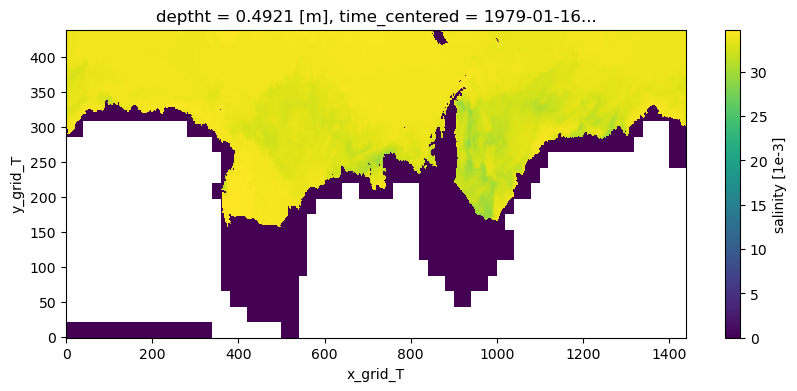

In [9]:
ds1.so.isel(time_counter=0, deptht=0).plot(figsize=(10,4))

In [100]:
file_list = glob.glob(f'{folder}output.abort_????.nc')
# file_list = glob.glob(f'{folder}output.init_????.nc')

Error:

```                     
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
                     
 kt 1 |ssh| max -1.7977+308 at i j    401 134     found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 |U|   max -1.7977+308 at i j k  424 146  22 found in   6 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   min  1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   max -1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
```

Tried halving the timestep and printing out the initial state. Other options:
- Use old bathymetry, starting from rest with all old conditions, icebergs off
- Use old bathymetry, starting from rest with new initial conditions for sea ice and T, S
- Use new bathymetry, starting from rest with all new conditions, but filling all zero/nan values in the forcing files with constants instead

In [ ]:
list_first = []
list_last  = [] 
for file in file_list:
    ds = xr.open_dataset(f'{file}', drop_variables=['x', 'y'])
    list_first.append(ds.attrs['DOMAIN_position_first'])
    list_last.append(ds.attrs['DOMAIN_position_last'])
    ds.close()

In [74]:
for i, ind in enumerate(list_first):
    if ind[0] <= 424 and (list_last[i][0] >= 424) and ind[1] <= 146 and (list_last[i][1] >= 146):
        print(i)

72


In [64]:
for i, ind in enumerate(list_first):
    if ind[0] <= 350 and (list_last[i][0] >= 350) and ind[1] <= 350 and (list_last[i][1] >= 350):
        print(i)

452


In [98]:
def xr_open_with_rename(fn, renames):
    ds    = xr.open_dataset(fn, drop_variables=renames.keys())    
    ds_nc = nc.Dataset(fn)
    for v in renames:
        nc_var=ds_nc[v]
        ds[renames[v]]= nc_var.dimensions, nc_var[...]
    ds_nc.close()
    ds = ds.set_coords(renames.values())    
    ds.to_netcdf(f"{folder}r-{fn.split('/')[-1]}")
    return ds

In [102]:
ds_issue = xr_open_with_rename(f'{file_list[72]}', dict(x="x_coord",y="y_coord"))

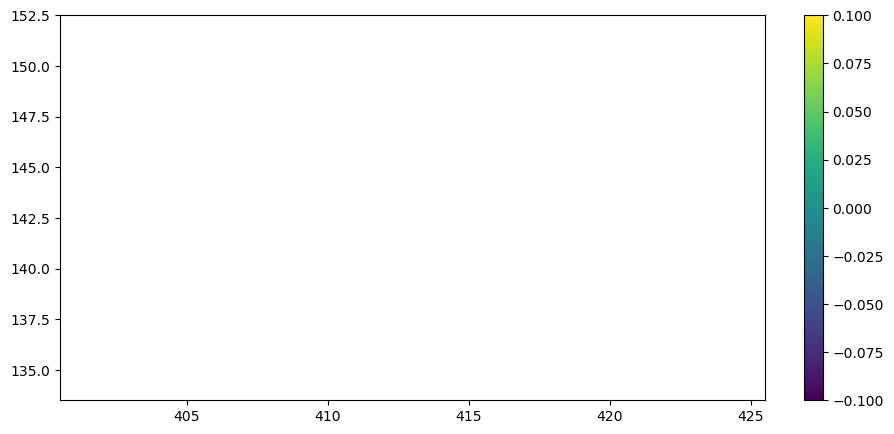

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=21).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

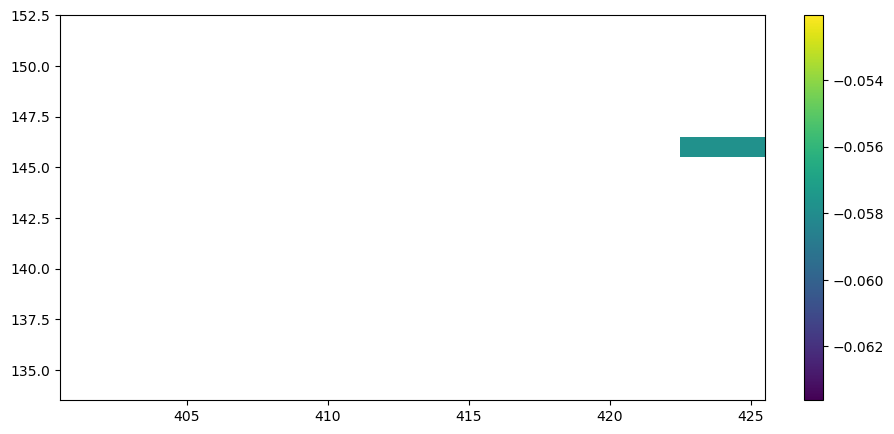

In [93]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

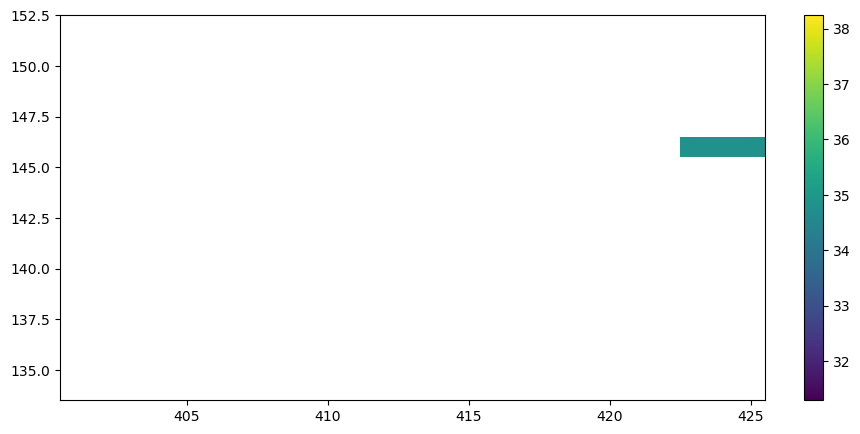

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.vosaline.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)